# MuseGAN 音乐生成 - 模型分析
## 引入

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from music21 import midi, note, stream, duration, converter, environment

from models.MuseGAN import MuseGAN
from utils.loaders import load_music

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

environment.Environment()['musicxmlPath'] = r'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe'
environment.Environment()['musescoreDirectPNGPath'] = r'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe'

## 环境参数

In [2]:
# run params
SECTION = 'compose'
RUN_ID = '0002'
DATA_NAME = 'chorales'
FILENAME = 'Jsb16thSeparated.npz'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

## 加载数据

In [3]:
BATCH_SIZE = 64
n_bars = 2
n_steps_per_bar = 16
n_pitches = 84
n_tracks = 4

data_binary, data_ints, raw_data = load_music(DATA_NAME, FILENAME, n_bars, n_steps_per_bar)

## 加载模型

In [4]:
gan = MuseGAN(
    input_dim=data_binary.shape[1:],
    critic_learning_rate=0.001,
    generator_learning_rate=0.001,
    optimizer='adam',
    grad_weight=10,
    z_dim=32,
    batch_size=BATCH_SIZE,
    n_tracks=n_tracks,
    n_bars=n_bars,
    n_steps_per_bar=n_steps_per_bar,
    n_pitches=n_pitches
)

gan.load_weights(RUN_FOLDER, None)
gan.generator.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
melody_input (InputLayer)       [(None, 4, 32)]      0                                            
__________________________________________________________________________________________________
chords_input (InputLayer)       [(None, 32)]         0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 32)           0           melody_input[0][0]               
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 32)           0           melody_input[0][0]               
___________________________________________________________________________________________

In [5]:
gan.critic.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    [(None, 2, 16, 84, 4)]    0         
_________________________________________________________________
conv3d (Conv3D)              multiple                  1152      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
conv3d_1 (Conv3D)            multiple                  16512     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    multiple                  0         
_________________________________________________________________
conv3d_2 (Conv3D)            multiple                  196736    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    multiple                  0     

## 音乐生成

c:\Users\86153\Anaconda3\envs\TensorFlow\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


array([53, 53, 52, 52], dtype=int64)

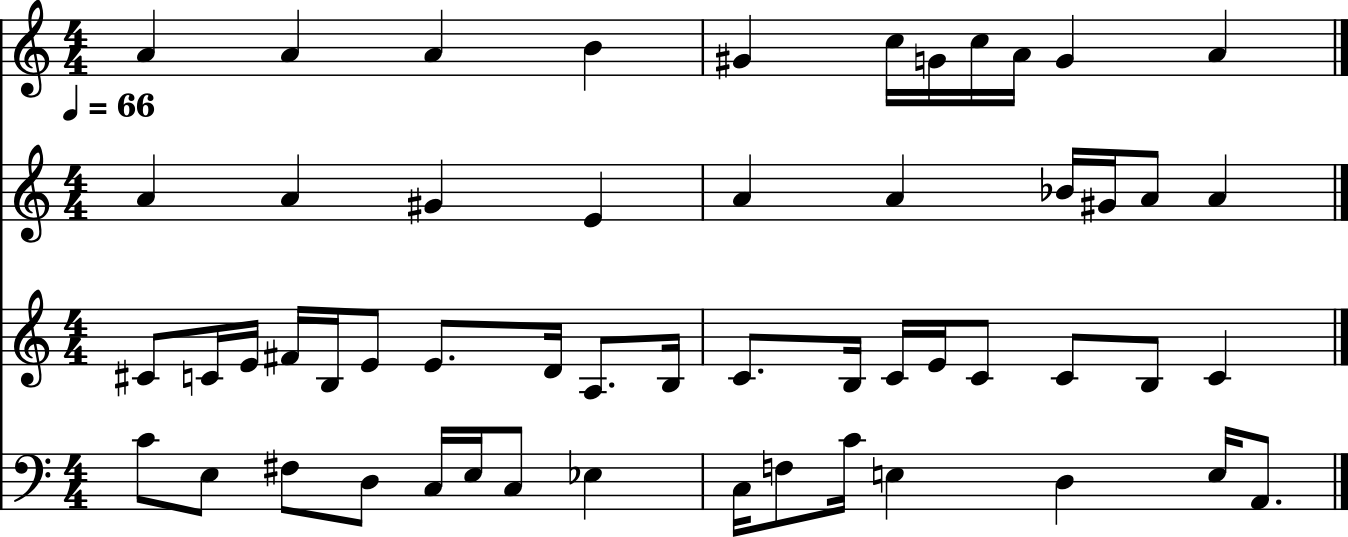

In [6]:
chords_noise = np.random.normal(0, 1, (1, gan.z_dim))
style_noise = np.random.normal(0, 1, (1, gan.z_dim))
melody_noise = np.random.normal(0, 1, (1, gan.n_tracks, gan.z_dim))
groove_noise = np.random.normal(0, 1, (1, gan.n_tracks, gan.z_dim))

gen_scores = gan.generator.predict(
    [chords_noise, style_noise, melody_noise, groove_noise])

np.argmax(gen_scores[0, 0, 0:4, :, 3], axis=1)
gen_scores[0, 0, 0:4, 60, 3] = 0.02347812

filename = 'example'
gan.notes_to_midi(RUN_FOLDER, gen_scores, filename)
gen_score = converter.parse(os.path.join(
    RUN_FOLDER, 'samples/{}.midi'.format(filename)))
gen_score.show()


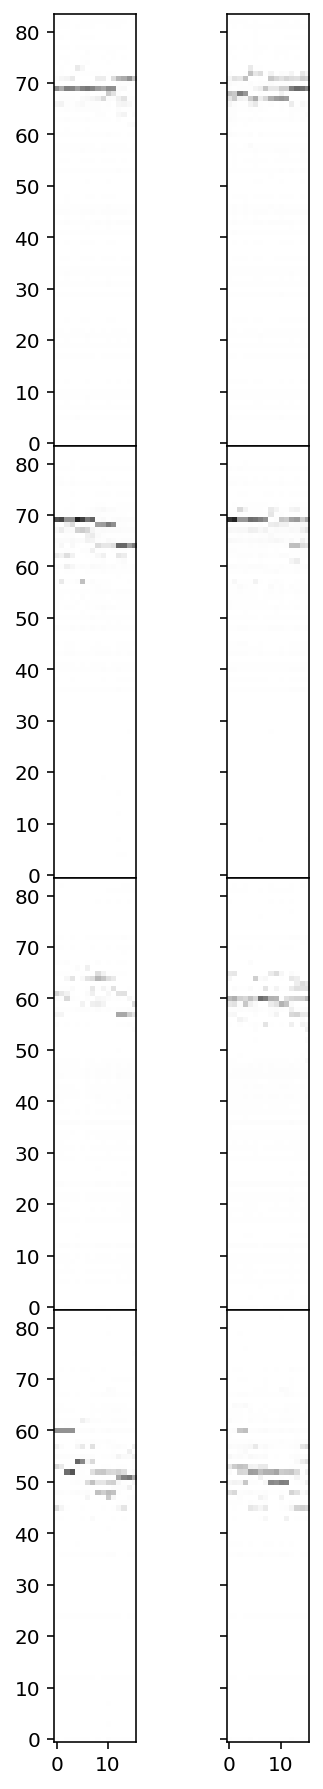

In [7]:
gan.draw_score(gen_scores, 0)

In [8]:
def find_closest(data_binary, score):
    current_dist = 99999999
    current_i = -1
    for i, d in enumerate(data_binary):
        dist = np.sqrt(np.sum(pow((d - score),2)))
        if dist < current_dist:
            current_i = i
            current_dist = dist
        
    return current_i

closest_idx = find_closest(data_binary, gen_scores[0])
closest_data = data_binary[[closest_idx]]
print(closest_idx)

106


original


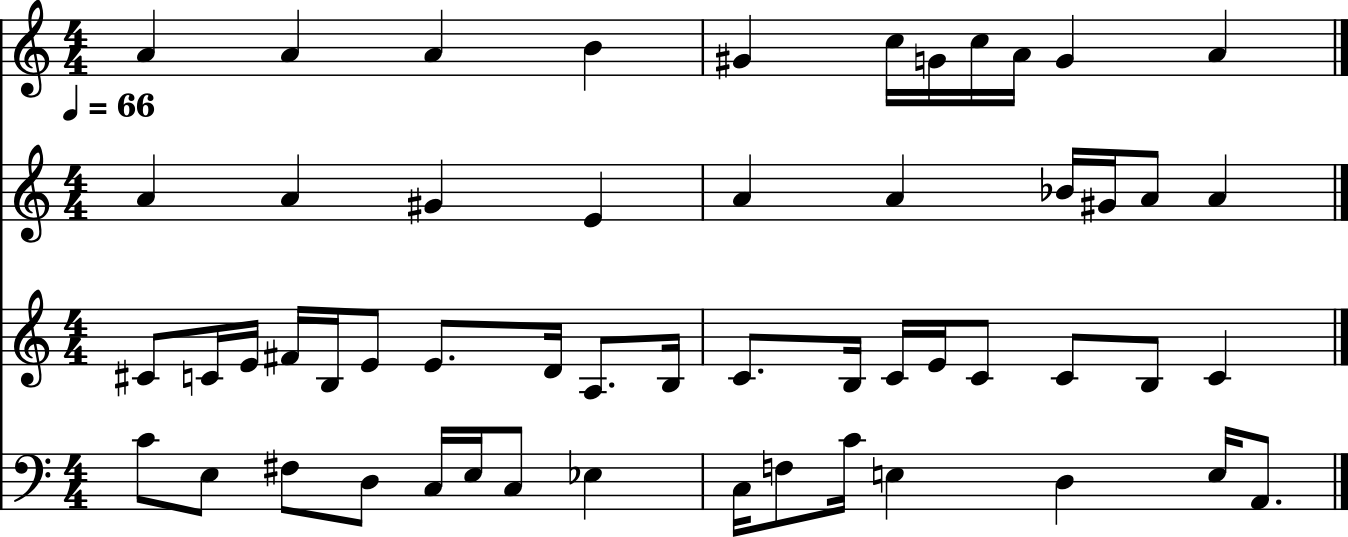

closest


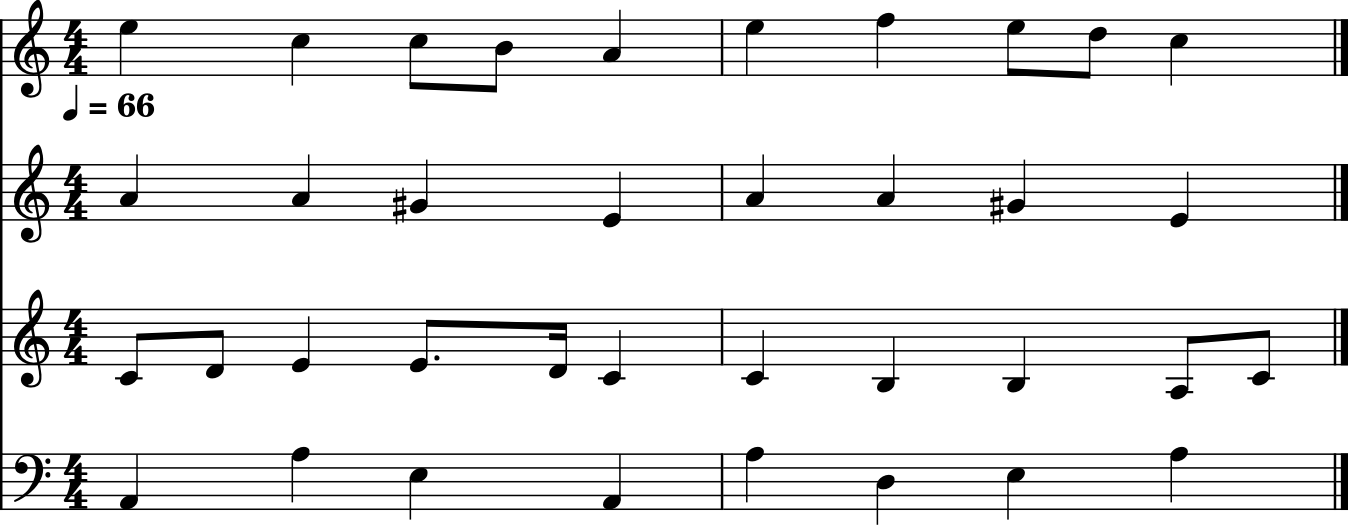

In [9]:
filename = 'closest'
gan.notes_to_midi(RUN_FOLDER, closest_data,filename)
closest_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('closest')
closest_score.show()

original


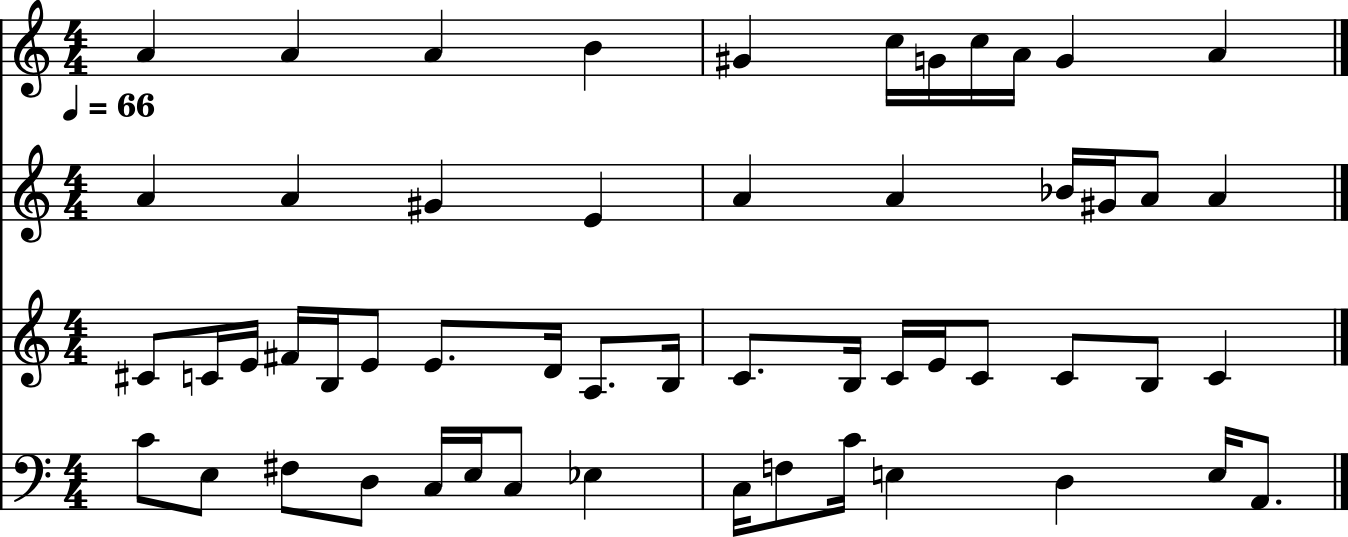

chords noise changed


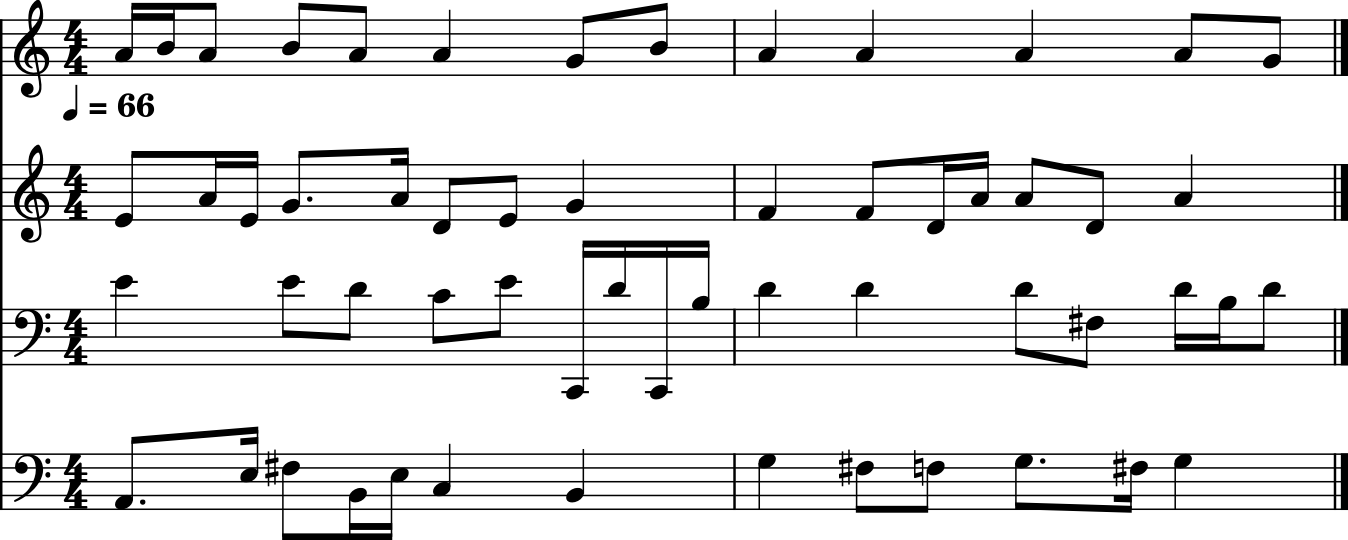

In [10]:
chords_noise_2 = 5 * np.ones((1, gan.z_dim))
chords_scores = gan.generator.predict([chords_noise_2, style_noise, melody_noise, groove_noise])

filename = 'changing_chords'
gan.notes_to_midi(RUN_FOLDER, chords_scores, filename)
chords_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('chords noise changed')
chords_score.show()

original


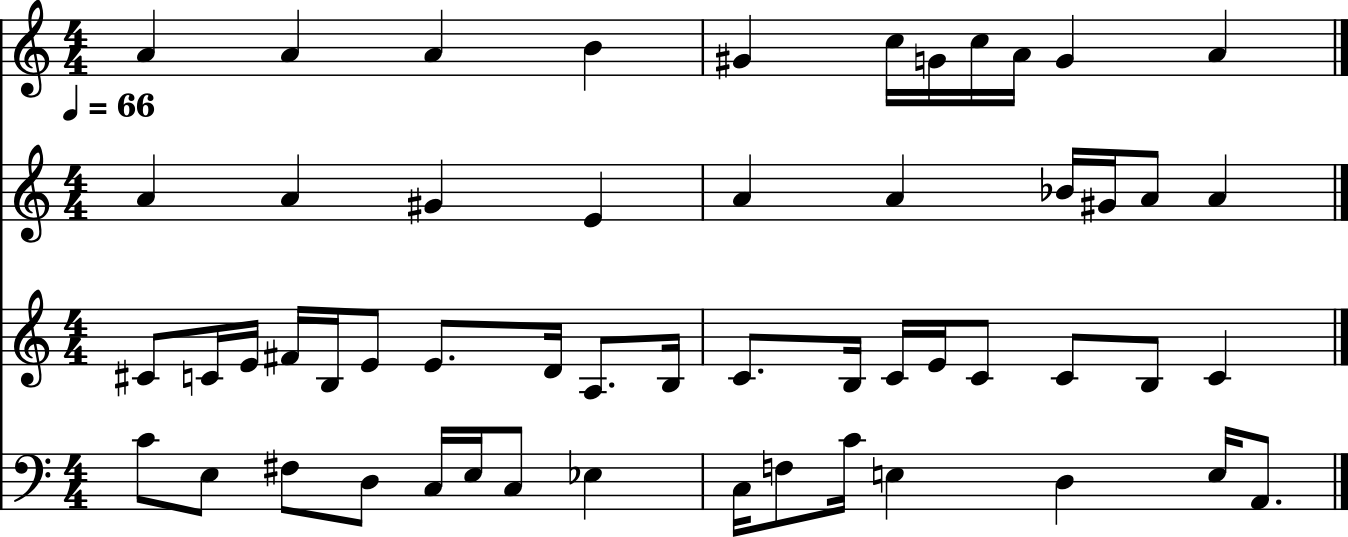

style noise changed


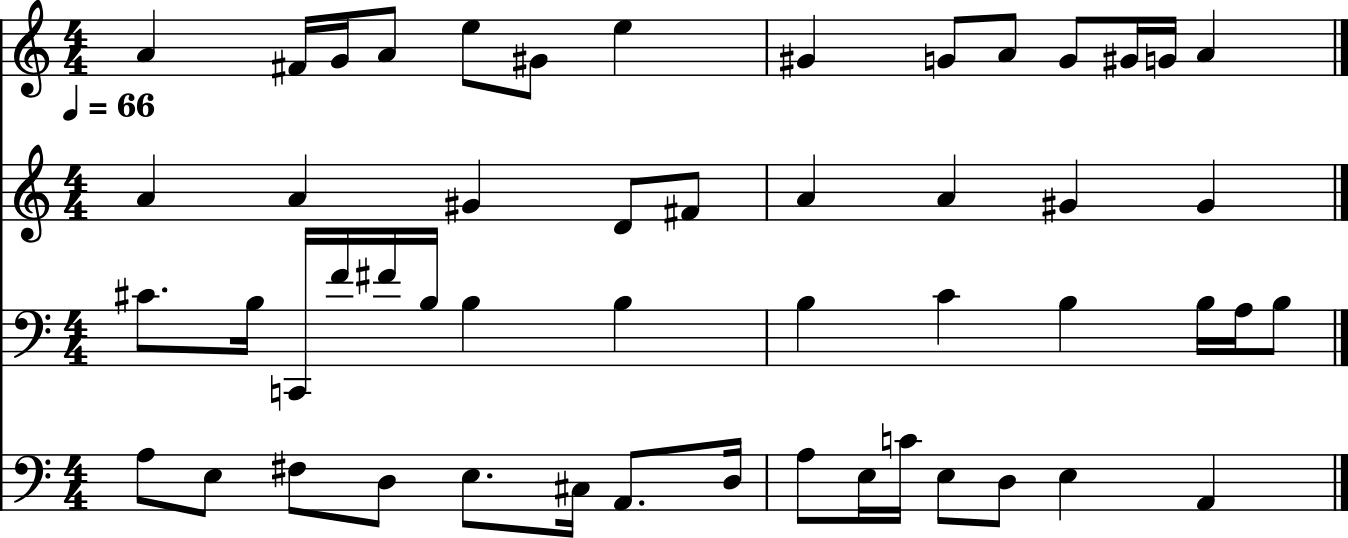

In [11]:
style_noise_2 = 5 * np.ones((1, gan.z_dim))
style_scores = gan.generator.predict([chords_noise, style_noise_2, melody_noise, groove_noise])

filename = 'changing_style'
gan.notes_to_midi(RUN_FOLDER, style_scores, filename)
style_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('style noise changed')
style_score.show()

original


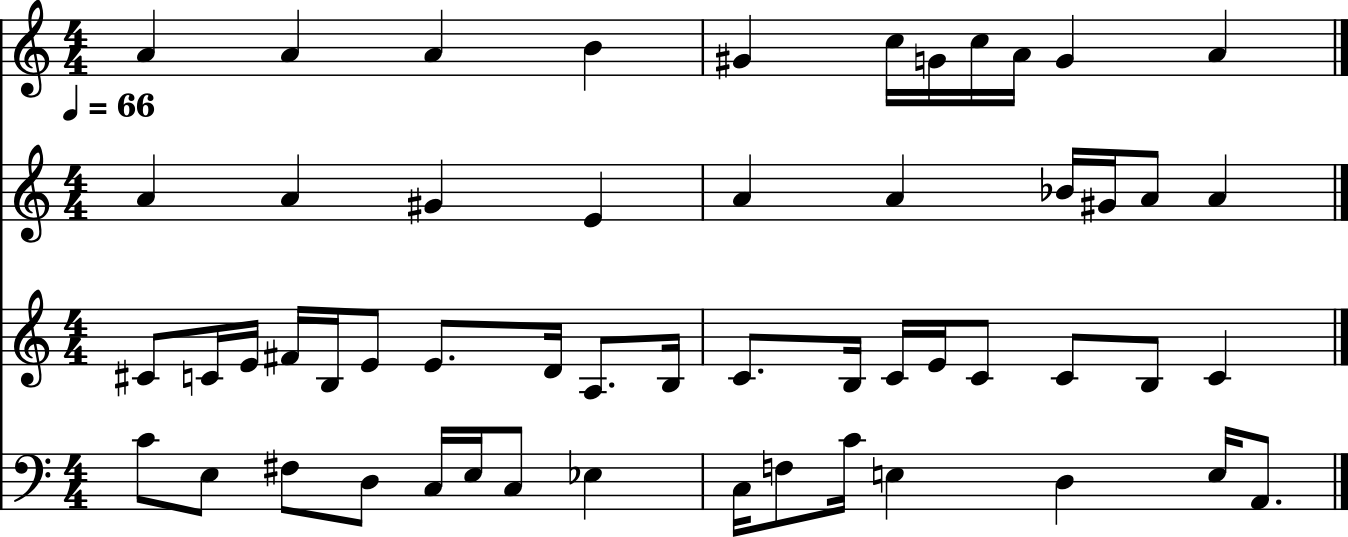

melody noise changed


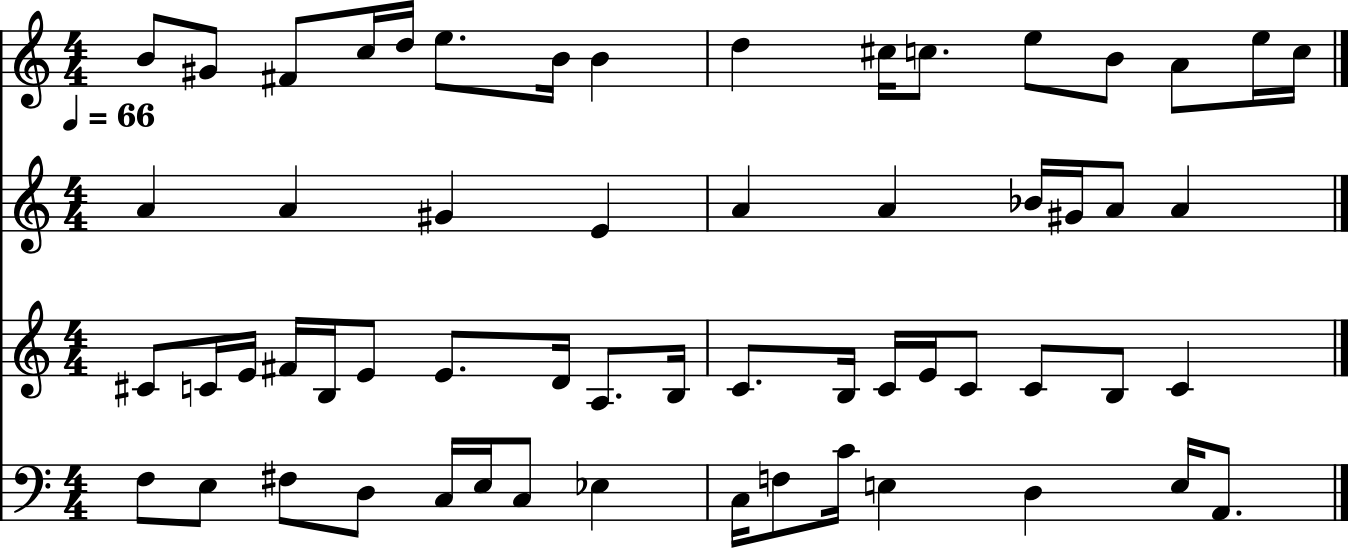

In [12]:
melody_noise_2 = np.copy(melody_noise)
melody_noise_2[0,0,:] = 5 * np.ones(gan.z_dim)
melody_scores = gan.generator.predict([chords_noise, style_noise, melody_noise_2, groove_noise])

filename = 'changing_melody'
gan.notes_to_midi(RUN_FOLDER, melody_scores, filename)
melody_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('melody noise changed')
melody_score.show()

original


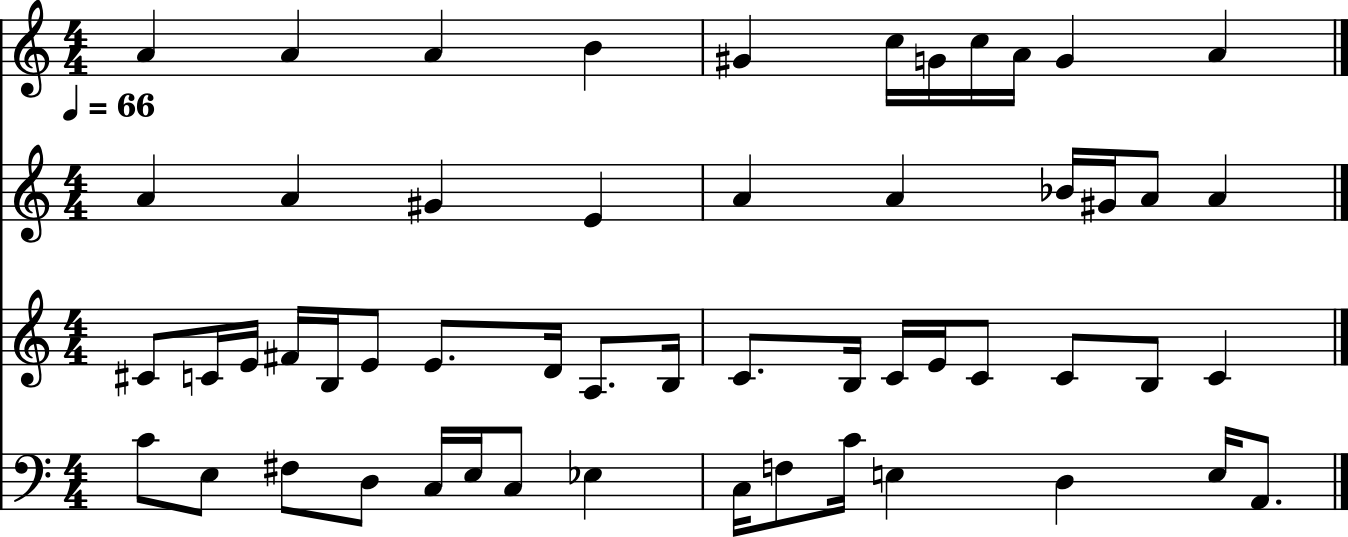

groove noise changed


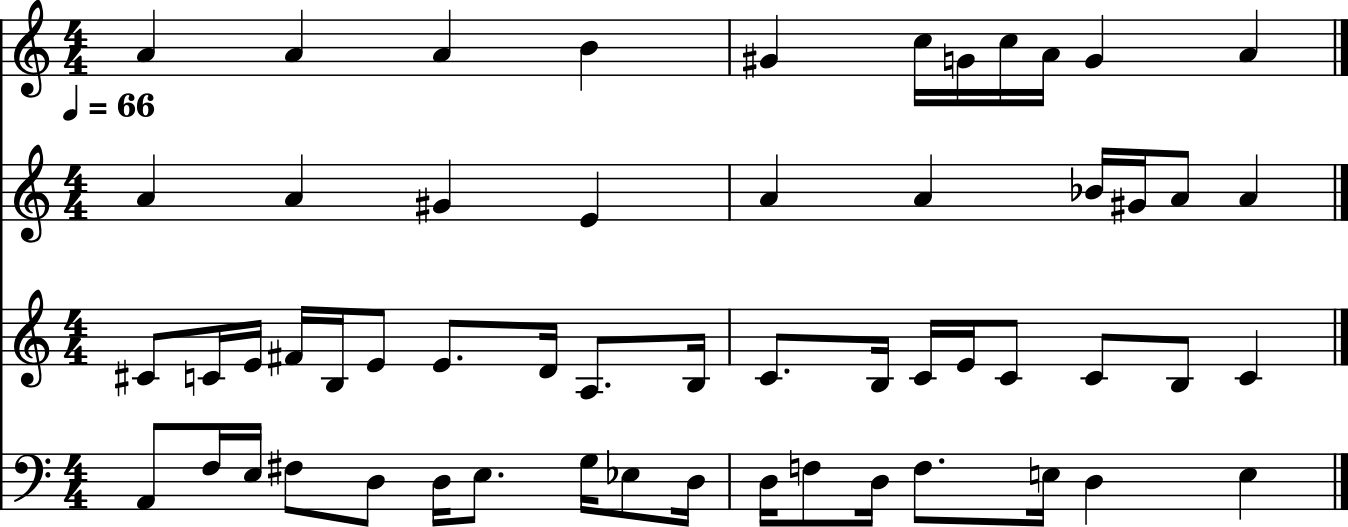

In [13]:
groove_noise_2 = np.copy(groove_noise)
groove_noise_2[0,3,:] = 5 * np.ones(gan.z_dim)
groove_scores = gan.generator.predict([chords_noise, style_noise, melody_noise, groove_noise_2])

filename = 'changing_groove'
gan.notes_to_midi(RUN_FOLDER, groove_scores, filename)
groove_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('groove noise changed')
groove_score.show()